In [1]:
import pandas as pd
from Libraries import preprocess_df as pre_df
from Libraries import signality_utilities as sign_u
from report_helper import signality_to_wyscout
from report_helper import preprocess_wyscout
from report_helper import addGameState
from report_helper import addTeamPossession
from report_helper import convert_metrics_frames
from report_helper import compute_metrics
from report_helper import take_closest
from report_helper import show_video
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
team_home_signality = 'Hammarby'
team_away_signality = 'HelsingborgsIF'
game_date = '20220402'

f = open('Data/'+game_date+'.'+signality_to_wyscout[team_home_signality]+'-'+signality_to_wyscout[team_away_signality]+'.json')
data = json.load(f)
wyscout_df = pd.DataFrame(data['events'])
df, game_info, success = pre_df.preprocess_signality(game_date+'.'+team_home_signality+'-'+team_away_signality, 'Data')
params = sign_u.default_model_params()

tracks_file = 'Data/'+game_date+'.'+team_home_signality+'-'+team_away_signality+'.1-tracks.json' 
with open(tracks_file) as f:
    tracks_json = json.load(f)
signality_df = pd.json_normalize(tracks_json)

preprocess_wyscout(wyscout_df, team_home_signality, team_away_signality)

addGameState(wyscout_df, df)
addTeamPossession(wyscout_df, df)
df_downsampled = df.iloc[::4, :].copy().reset_index()

df_downsampled['home_team_len'] = [len(x) for x in df_downsampled['home_team']]
df_downsampled['away_team_len'] = [len(x) for x in df_downsampled['away_team']]
df_downsampled['total_team_len'] = df_downsampled['home_team_len'] + df_downsampled['away_team_len']

Loading phase 1
Loading phase 2


# Example of Event Data

The event data provided by Wyscout contains different possible on-the-ball actions for a given football matches. Below, we can see passes with neccesary information about the relevant player, aswell as the origin and end coordinates. Similar rows exists for other events, such as tackles and shots.

In [3]:
wyscout_df_norm = pd.json_normalize(data['events'])
wyscout_df_norm[~pd.isna(wyscout_df_norm['pass.accurate'])].iloc[5:9][['id', 'matchTimestamp', 'player.name', 'pass.accurate', 'location.x', 'location.y', 'pass.endLocation.x', 'pass.endLocation.y']]

,id,matchTimestamp,player.name,pass.accurate,location.x,location.y,pass.endLocation.x,pass.endLocation.y
12,1238995773,00:00:21.505,A. Kaied,True,33.0,75.0,46.0,61.0
13,1238995776,00:00:23.402,A. van den Hurk,True,46.0,61.0,65.0,79.0
16,1238995918,00:00:28.155,D. Bojanić,True,29.0,17.0,9.0,29.0
17,1238995920,00:00:30.874,M. Fenger,True,9.0,29.0,5.0,44.0


# Example of Tracking Data

Each row has a home_team and away_team column, which is a list of all players which are tracked by the technology. Each player has a jersey number and a (x,y) coordinate. We also have the ball position as well as the timestamp of the frame

In [4]:
signality_df[['match_time', 'home_team', 'away_team', 'ball.position']].iloc[5:9]

,match_time,home_team,away_team,ball.position
5,215,"[{'jersey_number': 20, 'role': 2, 'position': ...","[{'jersey_number': 19, 'role': 2, 'position': ...","[-5.41, -1.55, 0.0]"
6,255,"[{'jersey_number': 20, 'role': 2, 'position': ...","[{'jersey_number': 19, 'role': 2, 'position': ...","[-5.74, -1.69, 0.0]"
7,295,"[{'jersey_number': 20, 'role': 2, 'position': ...","[{'jersey_number': 19, 'role': 2, 'position': ...","[-6.14, -1.79, 0.0]"
8,335,"[{'jersey_number': 20, 'role': 2, 'position': ...","[{'jersey_number': 19, 'role': 2, 'position': ...","[-6.54, -1.89, 0.0]"


In [5]:
for x in signality_df[['match_time', 'home_team', 'away_team', 'ball.position']].home_team.iloc[8][:3]:
    print('Home Player: ' + str(x['jersey_number']) + ' Coordinates: (' + str(x['position'][0])+','+str(x['position'][0])+')'  )
for x in signality_df[['match_time', 'home_team', 'away_team', 'ball.position']].away_team.iloc[8][:3]:
    print('Away Player: ' + str(x['jersey_number']) + ' Coordinates: (' + str(x['position'][0])+','+str(x['position'][0])+')'  )

Home Player: 20 Coordinates: (1.44,1.44)
Home Player: 8 Coordinates: (-9.61,-9.61)
Home Player: 6 Coordinates: (-7.27,-7.27)
Away Player: 19 Coordinates: (6.19,6.19)
Away Player: 30 Coordinates: (12.01,12.01)
Away Player: 9 Coordinates: (-1.54,-1.54)


A frame can easily be visualised, where the home team are the green vertices and away team the red vertices. The ball can also be seen as a black vertex close to player number 8 in green. 

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

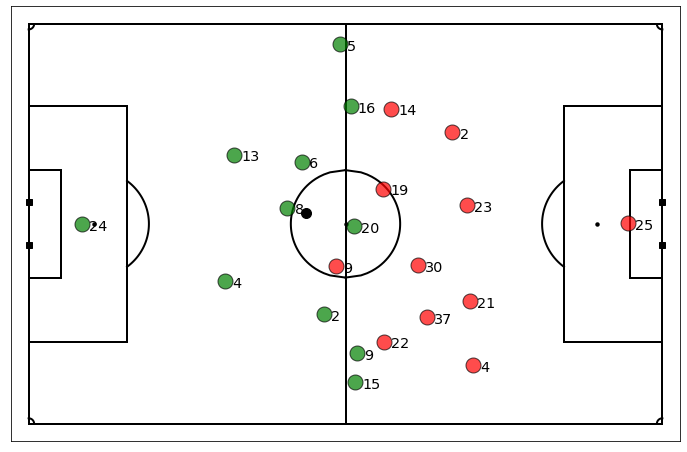

In [6]:
frame_to_plot = 8 # Frame number to plot
annotate = ['home', 'away'] # List of which teams to annotate jersey numbers

sign_u.plot_frame(df.iloc[frame_to_plot], annotate=annotate, team_colors=('g','r'))

# Pitch Control 

Pitch Control is the probability of controlling each zone on the pitch for a given team or player. An example of the Pitch Control model used in this thesis can be seen as a clip below. Green colours indicate control for the home team and red colours for the away team. Notice at 0:4.50, how two green players get behind the red team and lose pitch control. This is due to them being offside, and hence having a control rate of 0. 

In [7]:
start_frame = 8 # First frame in desired interval
end_frame = 300 # Last frame in desired interval
attacking_team = 'home' # Side of the attacking team ('home' or 'away')
sign_u.save_match_clip_pitchcontrol(df, start_frame, end_frame, '', game_info, params, attacking_team, fname="Clips/report_pc_1")

Generating movie...done


In [8]:
show_video("Clips/report_pc_1.mp4")

# Expected Possession Value

The pitch is divided in to a 32x50 grid. Each grid for the Expected Possession Value (EPV) represents the probability of transitioning from the given coordinate of the cell to a goal. This is a Markov Chain model developed by Laurie Shaw, based on historical data from real football matches. In the figure below, we can see how the grids around the goal have the highest values, assuming that the team is attacking from left to right. 

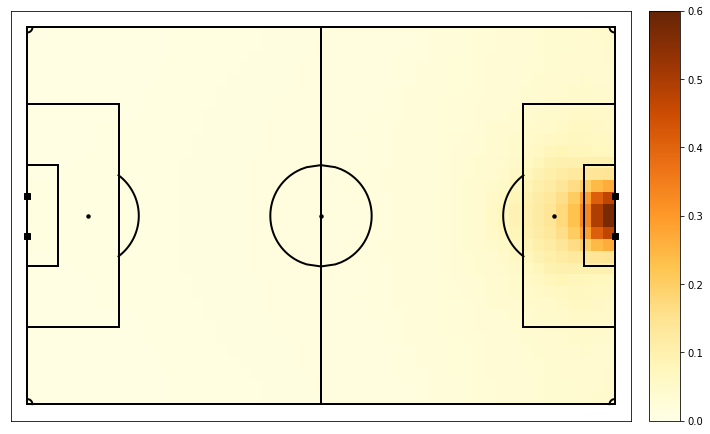

In [9]:
PI = sign_u.generate_pass_impact_for_frame(df, 0, game_info, 'home')
field_dimen=(106.0,68)
fig,ax = sign_u.plot_pitch(field_color='white', field_dimen = field_dimen)
im = ax.imshow(PI, extent=(-field_dimen[0]/2., field_dimen[0]/2., -field_dimen[1]/2., field_dimen[1]/2.),vmin=0.0,vmax=0.6,cmap='YlOrBr',alpha=1)

from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.25)
fig.colorbar(im, cax=cax, orientation='vertical')

# Pitch Control * EPV

By combining the two models above, we can multiply both matrices. In other words, we multiply the probability of controlling a grid by the probability of scoring given the coordinates. The resultant matrix are the pitch values. In the figure plotted below, green player number 9 is running with a significant velocity towards a zone which has high EPV values. Player number 9 is controlling a dangerous zone and thus creates high Pitch Control * EPV values. 

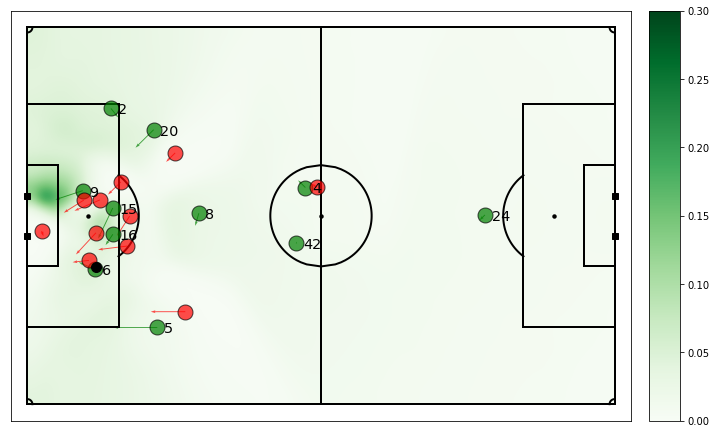

In [10]:
frame_plot = 90212

PI = sign_u.generate_pass_impact_for_frame(df, frame_plot, game_info, 'home')
PPCF,_,_,PPCF_players_att = sign_u.generate_pitch_control_for_frame(df, frame_plot, params, game_info, 'home')
fig,ax = sign_u.plot_pitch(field_color='white', field_dimen = field_dimen)
sign_u.plot_frame( df.iloc[frame_plot], figax=(fig,ax), team_colors=('g','r'), PlayerAlpha=0.7, include_player_velocities=True, annotate=['home'] )

PIxPPCF = PI*PPCF

im = ax.imshow(np.flipud(PIxPPCF),extent=(-field_dimen[0]/2., field_dimen[0]/2., -field_dimen[1]/2., field_dimen[1]/2.),vmin=0,vmax=0.3,interpolation='spline36',cmap='Greens',alpha=1)
field_dimen = (106.0,68)
from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.25)
fig.colorbar(im, cax=cax, orientation='vertical')

# Space Control

The first metric introduced for this thesis is called Space Control. The purpose of this is to capture movements of players which adds high goal scoring opportunities. In the figure above, player number 9 should thus be rewarded for his movement. This is computed by taking the individual Pitch Control * EPV, and looking at the highest value in the resultant matrix. 

The Space Control values for the frame above are computed below for each player in the last third of the pitch. We can see that player number 9 receives a Space Control value of  0.179. On the other hand, player number 2 does control a decent amount of the pitch, however in zones which are not as impactful in terms of goal scoring. Therefore, player number 2 receives a Space Control value of 0.050. 

In [11]:
contr = sign_u.pcpi_contribution(df.iloc[frame_plot], game_info, PPCF_players_att, PI, 'home')
for x in  contr:
    print("Home player " + str(x) + " has a Space Control of " + str(contr[x]))

Home player 2 has a Space Control of 0.04972905373119075
Home player 5 has a Space Control of 0.03729972278574183
Home player 6 has a Space Control of 0.0402006791703089
Home player 8 has a Space Control of 0.03341347164261931
Home player 9 has a Space Control of 0.1781902983218918
Home player 15 has a Space Control of 0.06869356206889224
Home player 16 has a Space Control of 0.03639354524975063
Home player 20 has a Space Control of 0.03798667688608821


# Space Generation

In the clip below, player number 16 makes a run towards the goal which attracts the opposition's defenders to follow. This creates free space behind player number 16, where player number 20 is lurking. From this clip, we can say that player number 16 generated space for player number 20. This is the purpose of Space Generation, which is done by comparing the Space Control values of neighboring team mates within a certain radius in a certain time interval. If the Space Control values in the radius are larger than at the origin of the run, the player making the run should be assigned the Space Control of the players within the radius. More intuitive examples are shown further below. 

In [12]:
sign_u.save_match_clip(df.iloc[130312:130312+80], "", fname="Clips/space_generation_example_1", team_colors=('g','r'), annotate=['home'])

Generating movie...done


In [13]:
show_video("Clips/space_generation_example_1.mp4")

## Start frame of player 16 making run
At the origin of the run, there is no neighbouring team mate within player 16's radius. 

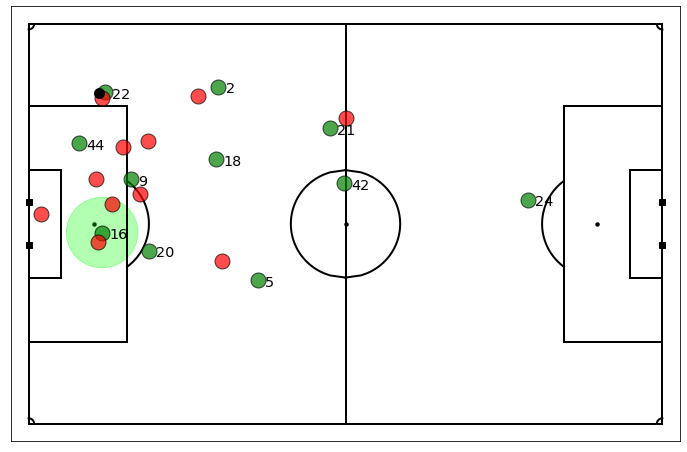

In [14]:
fig,ax = sign_u.plot_frame(df.iloc[130312], annotate=['home'], team_colors=('g','r'))
origin_pos = (df.iloc[130312]['home_team_aux.16.x'], df.iloc[130312]['home_team_aux.16.y'])
circle_init = plt.Circle(origin_pos, 6, color=(0,1,0), alpha=0.3)
ax.add_patch(circle_init)

## Within a time interval of maximum three seconds after the origin run
Player number 20, a team mate, has now entered the radius with a Space Control value of 0.1. Considering Player number 16 made a run of more than 4 metres within 3 seconds, and the Space Control value gain of his team mates within a radius of 6 metres is +0.1, a Space Generation value of 0.1 is also assigned to player number 16. He is deemed to have created this Space Control value for number 20, since he made a considerable run and there was a gain in Space Control in the origin position.

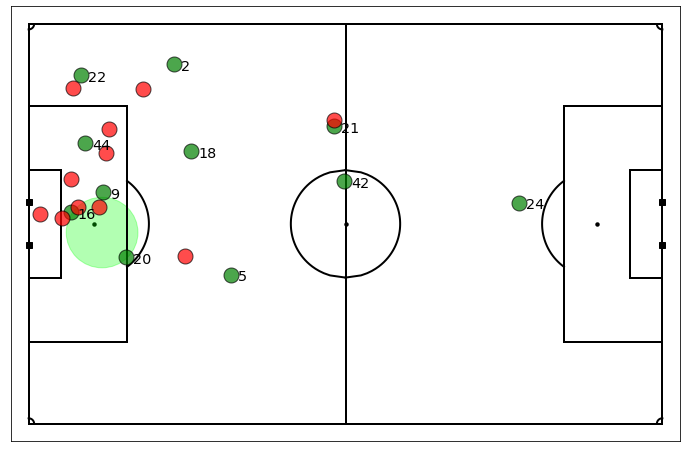

In [15]:
fig,ax = sign_u.plot_frame(df.iloc[130312+55], annotate=['home'], team_colors=('g','r'))
circle_init = plt.Circle(origin_pos, 6, color=(0,1,0), alpha=0.3)
ax.add_patch(circle_init)

# Assigning values for a full match

The purpose of the two implemented metrics is to identify players who create and generate space. Hence, we want to compute the metrics for every match in a season. This is done by first finding the attacking situations identified by the Wyscout event data. Each event in the Wyscout data belongs to a possession ID, such that for one given attacking situation all events belongs to the same possession. Each possession is also tagged with a 0 or 1 in attack, such that we can filter for only attacking possessions. 

In the dataframe below, we can see an attacking situation for team Hammarby, with all events corresponding to the given attacking situation. 

In [16]:
attacks_df = wyscout_df[(wyscout_df.set_piece==0) & (wyscout_df.throw_in == 0) & (wyscout_df.attack==1)].copy()
attacks_ids = attacks_df.possession_id.unique()
match_time_values = [df_downsampled[df_downsampled.phase==1]['match_time'], df_downsampled[df_downsampled.phase==2]['match_time']]

In [17]:
attack_id = 1238997213
attacks_df[attacks_df.possession_id==attack_id][['approx_match_time', 'team', 'player', 'primary_type', 'attack']]

,approx_match_time,team,player,primary_type,attack
1044,756568.0,"{'id': 6710, 'name': 'Hammarby', 'formation': ...","{'id': 56297, 'name': 'B. Paulsen', 'position'...",touch,1
1045,758396.0,"{'id': 6710, 'name': 'Hammarby', 'formation': ...","{'id': 56297, 'name': 'B. Paulsen', 'position'...",pass,1
1046,760527.0,"{'id': 6710, 'name': 'Hammarby', 'formation': ...","{'id': 388995, 'name': 'M. Jeahze', 'position'...",pass,1
1047,762384.0,"{'id': 6710, 'name': 'Hammarby', 'formation': ...","{'id': 56633, 'name': 'J. Andersen', 'position...",pass,1
1048,764188.0,"{'id': 6710, 'name': 'Hammarby', 'formation': ...","{'id': 56297, 'name': 'B. Paulsen', 'position'...",pass,1
1049,765084.0,"{'id': 6710, 'name': 'Hammarby', 'formation': ...","{'id': 56633, 'name': 'J. Andersen', 'position...",touch,1
1050,768619.0,"{'id': 6710, 'name': 'Hammarby', 'formation': ...","{'id': 56633, 'name': 'J. Andersen', 'position...",pass,1
1051,770232.0,"{'id': 6710, 'name': 'Hammarby', 'formation': ...","{'id': 51173, 'name': 'N. Besara', 'position':...",pass,1
1052,771665.0,"{'id': 6710, 'name': 'Hammarby', 'formation': ...","{'id': 169221, 'name': 'S. Sandberg', 'positio...",touch,1
1053,773401.0,"{'id': 6710, 'name': 'Hammarby', 'formation': ...","{'id': 169221, 'name': 'S. Sandberg', 'positio...",pass,1


The metrics we want to compute are only necessary for attacking situations, and thanks to the Wyscout event data we can take the match times of the first and last frame. Those are the intervals for which the computation of the metrics are interesting. We can then look at the frames in the tracking data between those timestamps. 

In [18]:
attacks_df_current = attacks_df[attacks_df.possession_id == attack_id].copy()
attack_start_time = int(attacks_df_current.approx_match_time.iloc[0])
attack_end_time = int(attacks_df_current.approx_match_time.iloc[-1])
attack_phase = int(attacks_df_current.matchPeriod.iloc[0].replace('H',''))
match_times = match_time_values[attack_phase-1]
team = attacks_df_current.possession_team.iloc[0]
team_name = attacks_df_current.iloc[0].possession['team']['name']

frame_start = match_times[match_times == take_closest(match_times.values, attack_start_time)].index[0]
frame_end = match_times[match_times == take_closest(match_times.values, attack_end_time)].index[0]

df_chain = df_downsampled.iloc[frame_start:frame_end+1].copy()
df_chain[['match_time', 'home_team', 'away_team', 'ball.position']]

,match_time,home_team,away_team,ball.position
22392,756576,"[{'jersey_number': 8, 'role': 2, 'position': [...","[{'jersey_number': 9, 'role': 2, 'position': [...","[43.46, 21.73, 0.0]"
22393,756736,"[{'jersey_number': 8, 'role': 2, 'position': [...","[{'jersey_number': 9, 'role': 2, 'position': [...","[43.79, 22.8, 0.0]"
22394,756896,"[{'jersey_number': 8, 'role': 2, 'position': [...","[{'jersey_number': 9, 'role': 2, 'position': [...","[44.05, 24.15, 0.0]"
22395,757056,"[{'jersey_number': 8, 'role': 2, 'position': [...","[{'jersey_number': 9, 'role': 2, 'position': [...","[44.58, 24.92, 0.0]"
22396,757216,"[{'jersey_number': 8, 'role': 2, 'position': [...","[{'jersey_number': 9, 'role': 2, 'position': [...","[44.58, 26.58, 0.0]"
...,...,...,...,...
22554,782496,"[{'jersey_number': 8, 'role': 2, 'position': [...","[{'jersey_number': 9, 'role': 2, 'position': [...","[-40.52, 8.93, 0.0]"
22555,782656,"[{'jersey_number': 8, 'role': 2, 'position': [...","[{'jersey_number': 9, 'role': 2, 'position': [...","[-40.57, 8.51, 0.0]"
22556,782816,"[{'jersey_number': 8, 'role': 2, 'position': [...","[{'jersey_number': 9, 'role': 2, 'position': [...","[-40.72, 8.15, 0.0]"
22557,782976,"[{'jersey_number': 8, 'role': 2, 'position': [...","[{'jersey_number': 9, 'role': 2, 'position': [...",None


For all these frames, we then compute the metrics Space Control and Space Generation. Then, we try to find the best combination of each metric, where for each player each value must be at least 3 seconds between. We can see all Space Control values assigned above 0.05 for the given attacking situation. We can see in the dataframe below that player number 9 has two values, which are 100 frames (4 seconds) apart.

In [19]:
df_metrics = compute_metrics(df_downsampled, attacks_df, attack_id, match_time_values, game_info, params)
df_metrics_new = df_metrics[df_metrics.run > 0.05][['team','player_nr','run','run_frame']].copy()
df_metrics_new.columns = ['Team', 'Player', 'Space Control', 'Frame']
df_metrics_new

,Team,Player,Space Control,Frame
0,home,9,0.178190,90212
1,home,9,0.053736,90112
3,home,15,0.068694,90212
6,home,16,0.073807,90156
8,home,6,0.060482,90116
11,home,2,0.055435,90220


In [20]:
freeze_frames = convert_metrics_frames(df_metrics)
sign_u.save_match_clip(df.iloc[frame_start*4:frame_end*4], '', 'Clips/metrics', team_colors=('g','r'), freeze_frames=freeze_frames, annotate=['home'])

Generating movie...done


The video below shows an example of how the values are assigned in practice. Each freezed frame shows which player was assigned Space Control or Space Generation value. The same process is then made for all attacking situations. We can see that for the same metric, the time between the assignments of the values are always larger than 3 seconds. 

In [21]:
show_video("Clips/metrics.mp4")

# Results

By executing the same process for all matches in Allsvenskan 2021, we can then sum all values for each player and normalize it per 90 minutes each player has played. The list are filtered for players with more than 600 minutes played. 

In [22]:
as_df = pd.read_csv('allsvenskan_fm.csv')
as_df = pd.merge(as_df, pd.read_csv('allsvenskan_xg.csv'), on='name')
as_df = as_df[['name','team','age','run_90','generation_90','fmrole']]
as_df.columns = ['Name', 'Team', 'Age', 'Space Control / 90 min', 'Space Generation / 90 min', 'fmrole']

as_df_s = as_df[as_df.fmrole=='S'].copy().drop(columns=['fmrole'])
as_df_am = as_df[as_df.fmrole=='AM'].copy().drop(columns=['fmrole'])
as_df_m = as_df[as_df.fmrole=='M'].copy().drop(columns=['fmrole'])

# Strikers top 10 Space Control

In [23]:
as_df_s.drop(columns=['Space Generation / 90 min']).sort_values(by=['Space Control / 90 min'], ascending=False).head(10).reset_index(drop=True)

,Name,Team,Age,Space Control / 90 min
0,Christoffer Nyman,IFKNorrköpingFK,29,1.531225
1,Nikola Djurdjic,DegerforsIF,36,1.352626
2,Kalle Holmberg,Djurgården,29,1.301456
3,Antonio-Mirko Čolak,MalmöFF,28,1.275658
4,Bojan Radulovic Samoukovic,AIK,22,1.274282
5,Astrit Selmani,Hammarby,25,1.264568
6,Jasse Tuominen,BKHäcken,26,1.239197
7,Christian Kouakou,IKSiriusFK,27,1.220290
8,Per Frick,IFElfsborg,30,1.100027
9,Marcus Antonsson,Halmstad,30,1.037956


# Strikers top 10 Space Generation

In [24]:
as_df_s.drop(columns=['Space Control / 90 min']).sort_values(by=['Space Generation / 90 min'], ascending=False).head(10).reset_index(drop=True)

,Name,Team,Age,Space Generation / 90 min
0,Christoffer Nyman,IFKNorrköpingFK,29,1.221977
1,Bojan Radulovic Samoukovic,AIK,22,0.948563
2,Per Frick,IFElfsborg,30,0.877646
3,Kalle Holmberg,Djurgården,29,0.815194
4,Jasse Tuominen,BKHäcken,26,0.749487
5,Antonio-Mirko Čolak,MalmöFF,28,0.734221
6,Christian Kouakou,IKSiriusFK,27,0.674325
7,Astrit Selmani,Hammarby,25,0.664908
8,Samuel Adegbenro,IFKNorrköpingFK,26,0.658615
9,Marcus Antonsson,Halmstad,30,0.634040


# Attacking Midfielders Space Control

In [25]:
as_df_am.drop(columns=['Space Generation / 90 min']).sort_values(by=['Space Control / 90 min'], ascending=False).head(10).reset_index(drop=True)

,Name,Team,Age,Space Control / 90 min
0,Joel Asoro,Djurgården,23,1.111937
1,Isak Jansson,KalmarFF,20,1.078862
2,Niklas Bärkroth,Djurgården,30,1.008245
3,Jacob Ondrejka,IFElfsborg,19,1.003864
4,Nils Fröling,KalmarFF,22,1.003804
5,Adi Nalić,MalmöFF,24,0.960563
6,Emmanuel Justine Rabby Banda,Djurgården,24,0.956283
7,Oliver Berg,KalmarFF,28,0.950591
8,Veljko Birmančević,MalmöFF,24,0.948245
9,Akinkunmi Amoo,Hammarby,19,0.938635


# Attacking Midfielders Space Generation

In [26]:
as_df_am.drop(columns=['Space Control / 90 min']).sort_values(by=['Space Generation / 90 min'], ascending=False).head(10).reset_index(drop=True)

,Name,Team,Age,Space Generation / 90 min
0,Isak Jansson,KalmarFF,20,0.706741
1,Joel Asoro,Djurgården,23,0.619746
2,Adi Nalić,MalmöFF,24,0.592444
3,Niklas Bärkroth,Djurgården,30,0.574069
4,Yukiya Sugita,IKSiriusFK,29,0.567095
5,Alexander Bernhardsson,IFElfsborg,23,0.563147
6,Emmanuel Justine Rabby Banda,Djurgården,24,0.514057
7,Oliver Berg,KalmarFF,28,0.491130
8,Noah Shamoun,KalmarFF,19,0.486987
9,Kevin Yakob,IFKGöteborg,21,0.484743


# Midfielders Space Control

In [27]:
as_df_m.drop(columns=['Space Generation / 90 min']).sort_values(by=['Space Control / 90 min'], ascending=False).head(10).reset_index(drop=True)

,Name,Team,Age,Space Control / 90 min
0,Erik Lindell,DegerforsIF,26,0.791373
1,Vladimir Rodić,Hammarby,28,0.790047
2,Williot Swedberg,Hammarby,18,0.771137
3,Adam Ståhl,IKSiriusFK,27,0.752153
4,Simon Olsson,IFElfsborg,24,0.739402
5,Anders Bleg Christiansen,MalmöFF,31,0.719555
6,Moustafa Zeidan,IKSiriusFK,23,0.645493
7,Hampus Finndell,Djurgården,21,0.639472
8,Dennis Collander,Örebro,19,0.630172
9,Axel Lindahl,DegerforsIF,27,0.628881


# Midfielders Space Generation

In [28]:
as_df_m.drop(columns=['Space Control / 90 min']).sort_values(by=['Space Generation / 90 min'], ascending=False).head(10).reset_index(drop=True)

,Name,Team,Age,Space Generation / 90 min
0,Simon Olsson,IFElfsborg,24,0.460235
1,Anders Bleg Christiansen,MalmöFF,31,0.439280
2,Williot Swedberg,Hammarby,18,0.431721
3,Hampus Finndell,Djurgården,21,0.366266
4,Kristoffer Khazeni,IFKNorrköpingFK,26,0.322693
5,Ísak Bergmann Jóhannesson,IFKNorrköpingFK,19,0.314135
6,Moustafa Zeidan,IKSiriusFK,23,0.299341
7,Johan Karlsson,IKSiriusFK,20,0.286115
8,Robert Gojani,IFElfsborg,29,0.285408
9,Dennis Collander,Örebro,19,0.279834
